In [44]:
# Manipultation
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as grid_spec
from matplotlib.ticker import PercentFormatter
#network tool
import networkx as nx
# Utils
import zipfile
%matplotlib inline


In [45]:
#Unzip files
if zipfile.is_zipfile("archive.zip"):
    with zipfile.ZipFile("archive.zip","r") as archive:
        archive.extractall()
            
else:
    print("Not a zip file")


In [46]:
customer = pd.read_csv(r"olist_customers_dataset.csv")
geolocation = pd.read_csv(r"olist_geolocation_dataset.csv")
sellers = pd.read_csv(r"olist_sellers_dataset.csv")
orders = pd.read_csv(r"olist_orders_dataset.csv")

# convert date columns to dateformat
date_cols = orders.columns[3:]
orders[date_cols] = orders[date_cols].apply(pd.to_datetime)
#filter the undelivered orders
#orders = orders[orders["order_status"]=="delivered"]
#create time and day columns
orders["daysToDeliver"] = (orders["order_delivered_customer_date"] - orders["order_delivered_carrier_date"]).dt.days
orders["purchased_month"] = orders["order_purchase_timestamp"].dt.month
orders["purchased_hour_day"] = orders["order_purchase_timestamp"].dt.hour
orders["purchased_day"] = orders["order_purchase_timestamp"].dt.day
orders["purchased_week_day"] = orders["order_purchase_timestamp"].dt.dayofweek
orders.drop(columns=["order_approved_at","order_delivered_carrier_date",
                     "order_delivered_customer_date","order_estimated_delivery_date"],inplace=True)
orders["order_purchase_timestamp"] = orders["order_purchase_timestamp"].dt.date
# merge with customers
orders = orders.merge(customer[["customer_id","customer_state"]],on="customer_id",how="left")

# lets filter outliers
orders = orders[orders["daysToDeliver"]>=0]
orders = orders[(np.abs(stats.zscore(orders["daysToDeliver"])) < 3)]

# Import orders items
orders_items = pd.read_csv(r"olist_order_items_dataset.csv")
# Import category data set and join
category_por = pd.read_csv(r"olist_products_dataset.csv")
category_eng = pd.read_csv(r"product_category_name_translation.csv")

category = (category_por.merge(category_eng,right_on="product_category_name",
                          left_on="product_category_name",how="left").drop(["product_category_name"],axis=1).
           rename({"product_category_name_english":"category"},axis=1))

orders_items = orders_items.merge(category,on="product_id",how="left")

# convert date columns to date format
orders_items["shipping_limit_date"] = pd.to_datetime(orders_items["shipping_limit_date"])

# Merge to main df
orders = orders.merge(orders_items,on="order_id",how="left")

#payments
#many payments for 1 order_id, so we have to groupby before merging
orders_payment = pd.read_csv(r"olist_order_payments_dataset.csv")

orders_payment = orders_payment.groupby("order_id",as_index=False).agg({"payment_sequential":"max",
                                                            "payment_value":"sum",
                                                            "payment_type":"max"})

orders = orders.merge(orders_payment,on="order_id",how="left")

orders = orders.merge(sellers[['seller_id','seller_state']],on="seller_id",how="left")

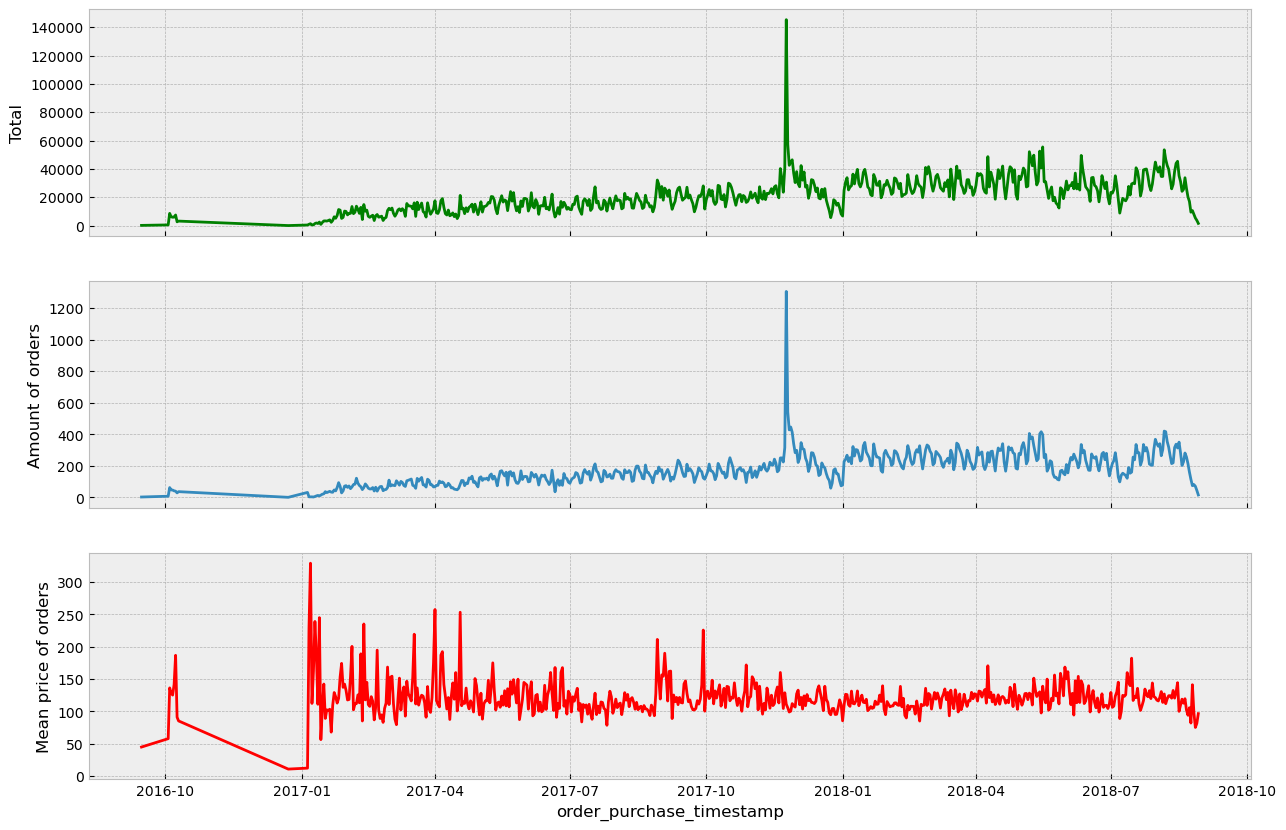

In [47]:
orders_time = orders.groupby("order_purchase_timestamp").agg({"price":["mean","sum","count"]}).reset_index()

fig, ax = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","sum"),color="green",ax=ax[0])
ax[0].set_ylabel("Total")
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","count"),ax=ax[1])
ax[1].set_ylabel("Amount of orders")
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","mean"),color="red",ax=ax[2])
ax[2].set_ylabel("Mean price of orders")
plt.show()

outlier_date = (orders_time.sort_values(("price","count"),
                                        ascending=False).iloc[:1]["order_purchase_timestamp"].values)[0]

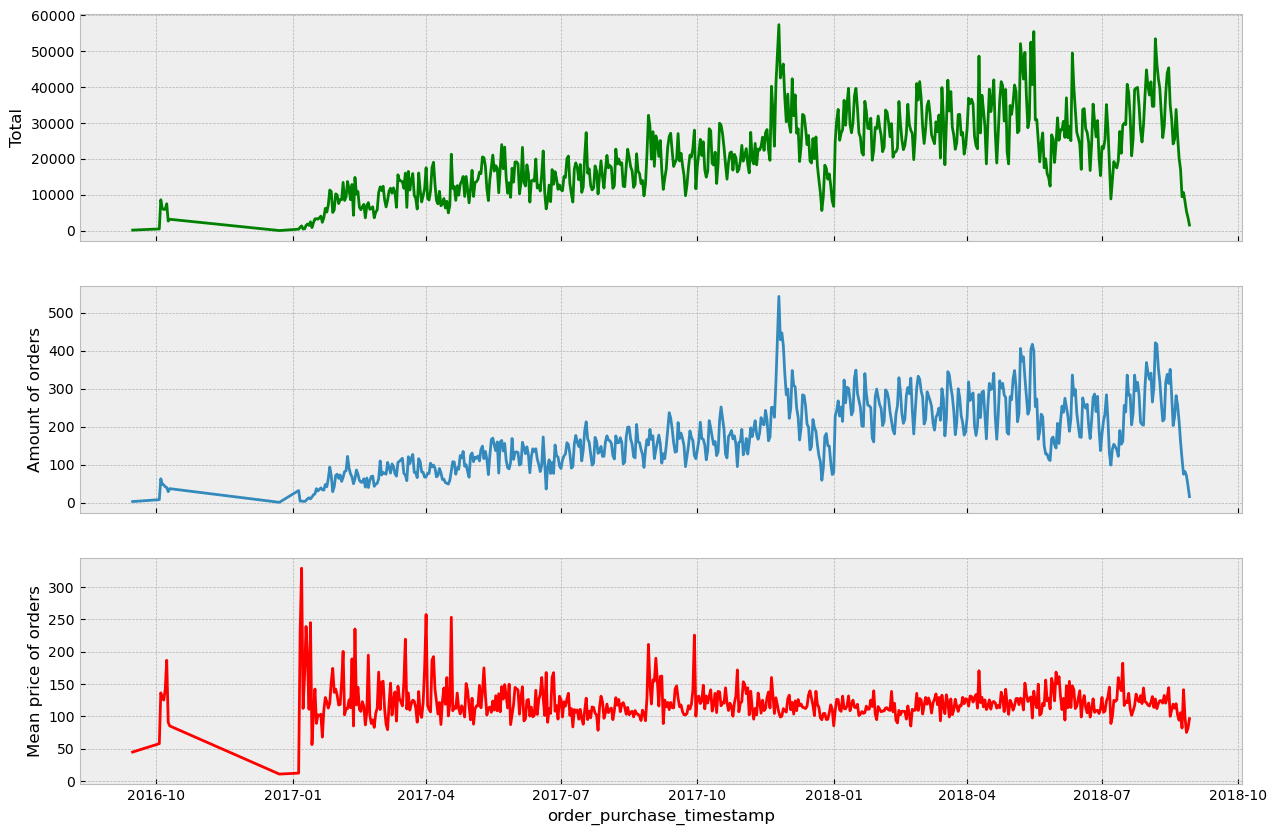

In [48]:
orders = orders[orders["order_purchase_timestamp"]!=outlier_date]

orders_time = orders.groupby("order_purchase_timestamp").agg({"price":["mean","sum","count"]}).reset_index()

fig, ax = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","sum"),color="green",ax=ax[0])
ax[0].set_ylabel("Total")
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","count"),ax=ax[1])
ax[1].set_ylabel("Amount of orders")
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","mean"),color="red",ax=ax[2])
ax[2].set_ylabel("Mean price of orders")
plt.show()

In [49]:
def check_unique(data):
    '''
    Check if each column of the df has unique values
    '''
    for column in data.columns:
        print(f'{column}: {data[column].is_unique}')
        

In [50]:
def plot_pareto(df,col,threshold=70):
    new_col = "cum_percent"
    X = df.copy()
    X[new_col] = X[col].cumsum() / X[col].sum()*100
    axis_threshold = X[X[new_col]<=threshold].index
    color1 = "red"
    color2 = "steelblue"
    line_size = 4
    
    fig,ax = plt.subplots(figsize=(15,7))
    ax.bar(X.index,X[col],color=color2)
 
    ax2 = ax.twinx()
    ax2.plot(X.index,X[new_col],color=color1,marker="D",ms=line_size)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y",colors=color2)
    ax.tick_params(axis="x",labelrotation=30)
    ax2.tick_params(axis="y",colors=color1,grid_alpha=0)
    
    plt.show()
    print(f'Categories covering {threshold}%: {axis_threshold.values}')

#### Analisis de Ordenes

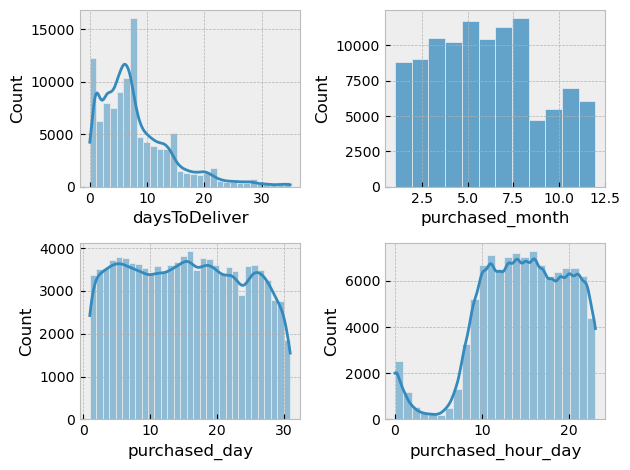

In [51]:
fig, ax = plt.subplots(2,2)
sns.histplot(data=orders,x="daysToDeliver",ax=ax[0,0],bins=30,kde=True)
sns.histplot(data=orders,x="purchased_month",ax=ax[0,1],bins=12)
sns.histplot(data=orders,x="purchased_day",ax=ax[1,0],bins=31,kde=True)
sns.histplot(data=orders,x="purchased_hour_day",ax=ax[1,1],bins=24,kde=True)
plt.tight_layout()

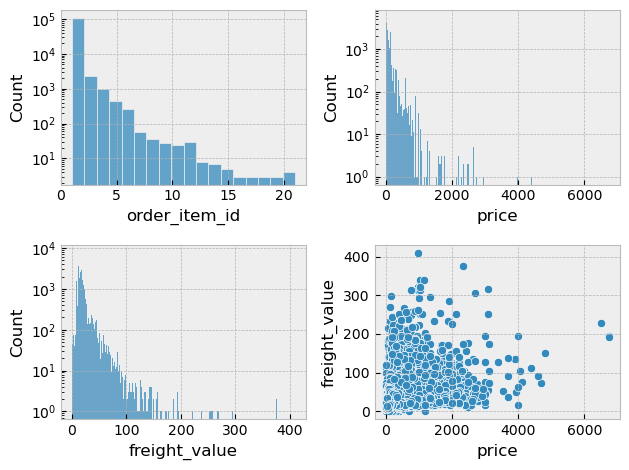

In [52]:
fig,ax = plt.subplots(nrows=2,ncols=2)
sns.histplot(orders_items["order_item_id"],ax=ax[0,0],log=True)
sns.histplot(orders_items["price"],ax=ax[0,1],log=True)
sns.histplot(orders_items["freight_value"],ax=ax[1,0],log=True)
sns.scatterplot(x=orders_items["price"],y=orders_items["freight_value"],ax=ax[1,1])
plt.tight_layout()

#### Aqui se abre el analsisi al hacer el group by con order_id, para hacer analisis x orden.
Luego tendre que usar otro group by para el analisis de los productos y de los vendedores

In [53]:
#Each order_id can have several sellers and items at the same time
order_total = orders_items.groupby("order_id").agg({
        "order_item_id":"count",
        "price":"sum",
        "freight_value":"sum",
        "seller_id":"count"
}).rename({"order_item_id":"items_amount","seller_id":"sellers_amount","price":"total_consumption"},axis=1)


order_total = order_total.merge(orders,left_index=True,right_on="order_id")



Que habito de compra tiene cada estado? Hay algun estado con habitos de compra fuera de lo normal?

In [79]:
orders_by_state = (orders.groupby("customer_state",as_index=False).agg({
                                "price":["median","sum"],"freight_value":"median"}).
                   rename({"price":"consumption"},axis=1)).sort_values(by=("consumption","sum"),ascending=False)

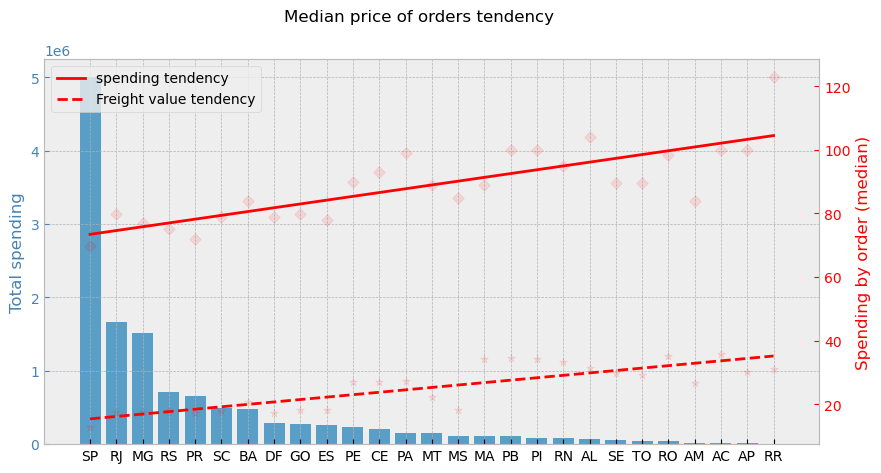

In [112]:
plt.style.use("bmh")
x= range(len(orders_by_state["customer_state"]))
reg1 = stats.linregress(x,orders_by_state["consumption"]["median"].values)
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x=orders_by_state["customer_state"].values,
       height=orders_by_state["consumption"]["sum"],alpha=0.8)
ax2 = ax.twinx()
ax2.scatter(orders_by_state["customer_state"].values,
            orders_by_state["consumption"]["median"],color="red",marker="D",alpha=0.1)
ax2.plot(x,reg1.intercept+reg1.slope*x,color="red",label="spending tendency")
ax2.tick_params(axis="y",colors="red",grid_alpha=0)
ax2.scatter(orders_by_state["customer_state"],
            orders_by_state["freight_value"],marker="*",color="red",alpha=0.1)
reg2 = stats.linregress(x,orders_by_state["freight_value"].values[:,0])
ax2.plot(x,reg2.intercept+reg2.slope*x,color="red",
         label="Freight value tendency",linestyle="--")
ax.set_ylabel("Total spending",color="steelblue")
ax.tick_params(axis="y",colors="steelblue")
ax2.set_ylabel("Spending by order (median)",color="red")
fig.suptitle("Median price of orders tendency")
plt.legend()
plt.show()

Text(0.5, 0, 'State')

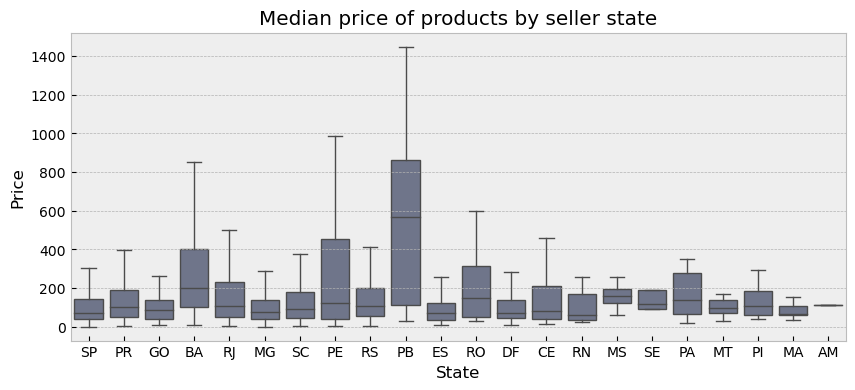

In [56]:
products_by_state = (orders.groupby(["product_id","seller_state"],as_index=False).
                     agg({"price":["mean","median"]})).sort_values(by=("price","median"),ascending=False)
fig, ax = plt.subplots(figsize=(10,4))
palette = sns.color_palette("magma")
ax = sns.boxplot(data=products_by_state,x="seller_state",
                 y=("price","median"),color="#6B728E",showfliers=False,linewidth=1)

ax.set_title("Median price of products by seller state")
ax.set_ylabel("Price")
ax.set_xlabel("State")

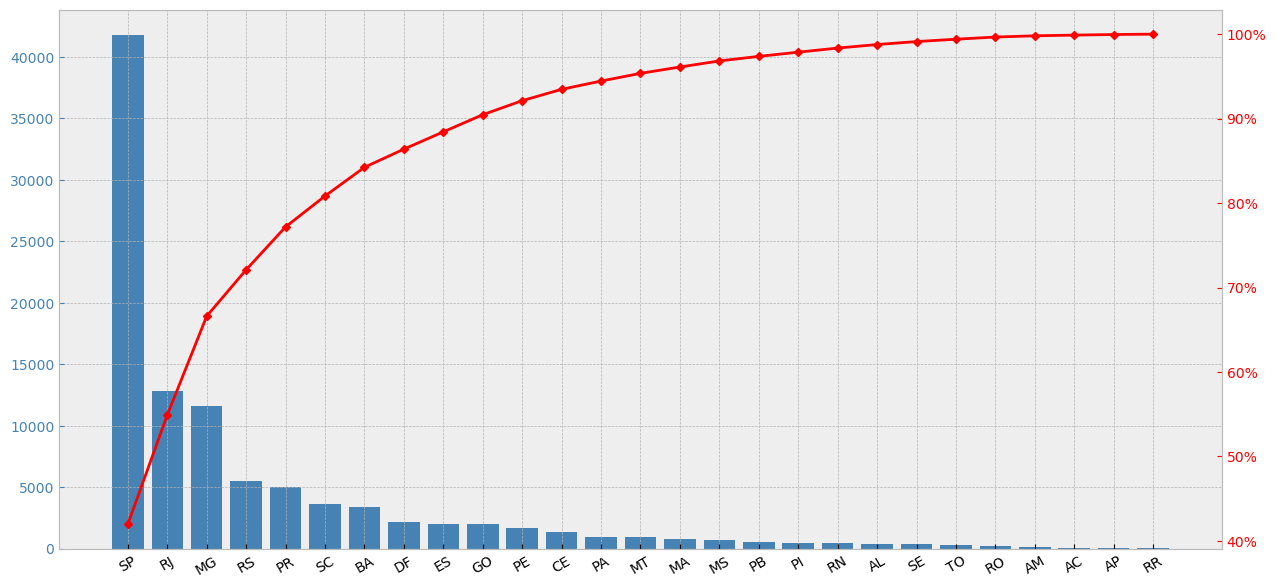

Categories covering 75%: ['SP' 'RJ' 'MG' 'RS']


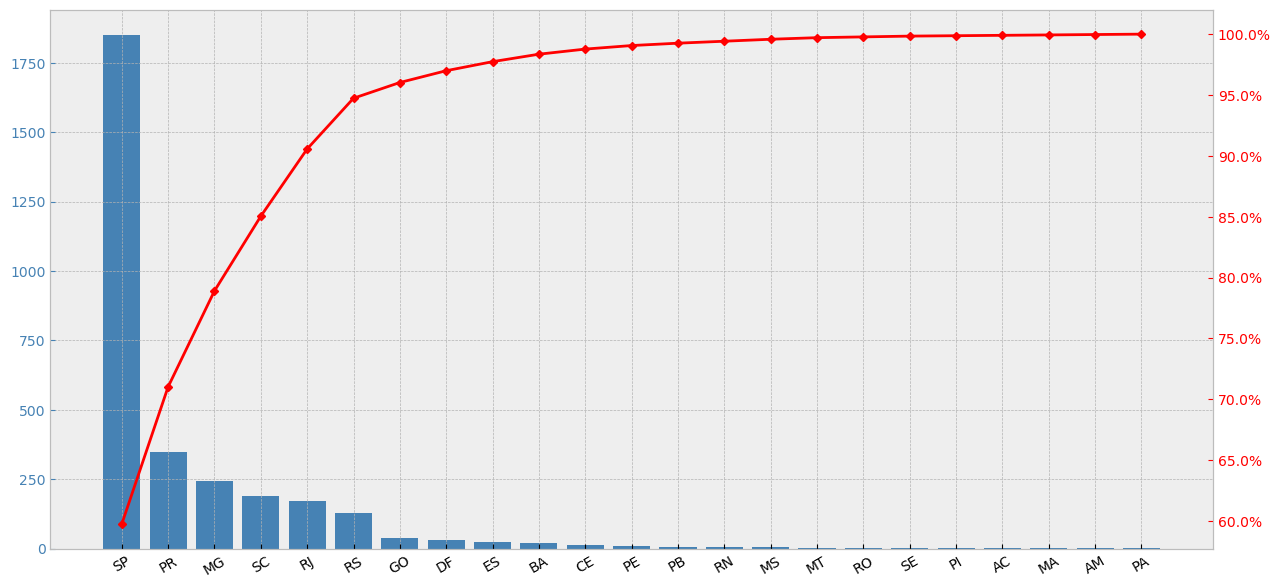

Categories covering 70%: ['SP']


In [57]:
#amount of customer and sellers by city and state
city_customer_amount = pd.DataFrame(customer["customer_city"].value_counts())
state_customer_amount = pd.DataFrame(customer["customer_state"].value_counts())
#plot it
plot_pareto(state_customer_amount,"customer_state",threshold=75)

# Amount of sellers by city and state
city_seller_amount = pd.DataFrame(sellers["seller_city"].value_counts())
state_seller_amount = pd.DataFrame(sellers["seller_state"].value_counts())
# plot it
plot_pareto(state_seller_amount,"seller_state")

Ill take the 4 biggest states in onsumption and see how their consuming behaviour

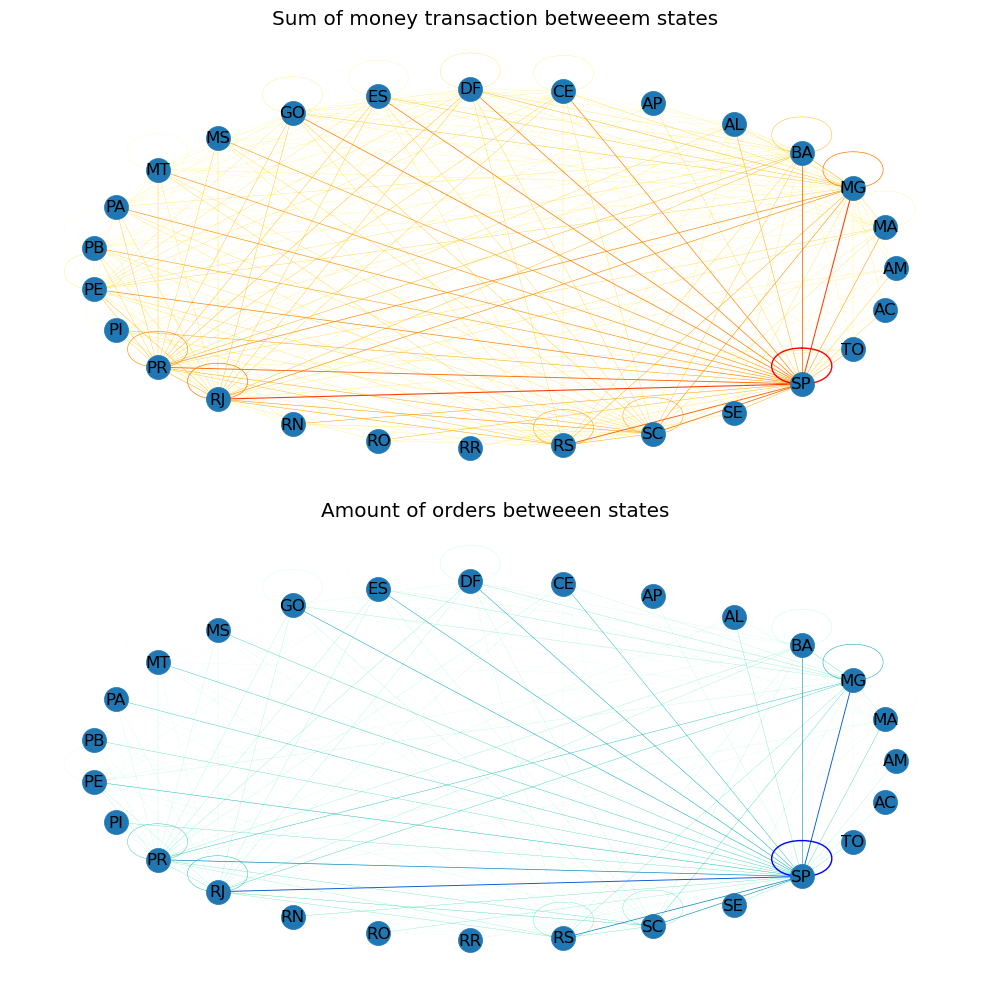

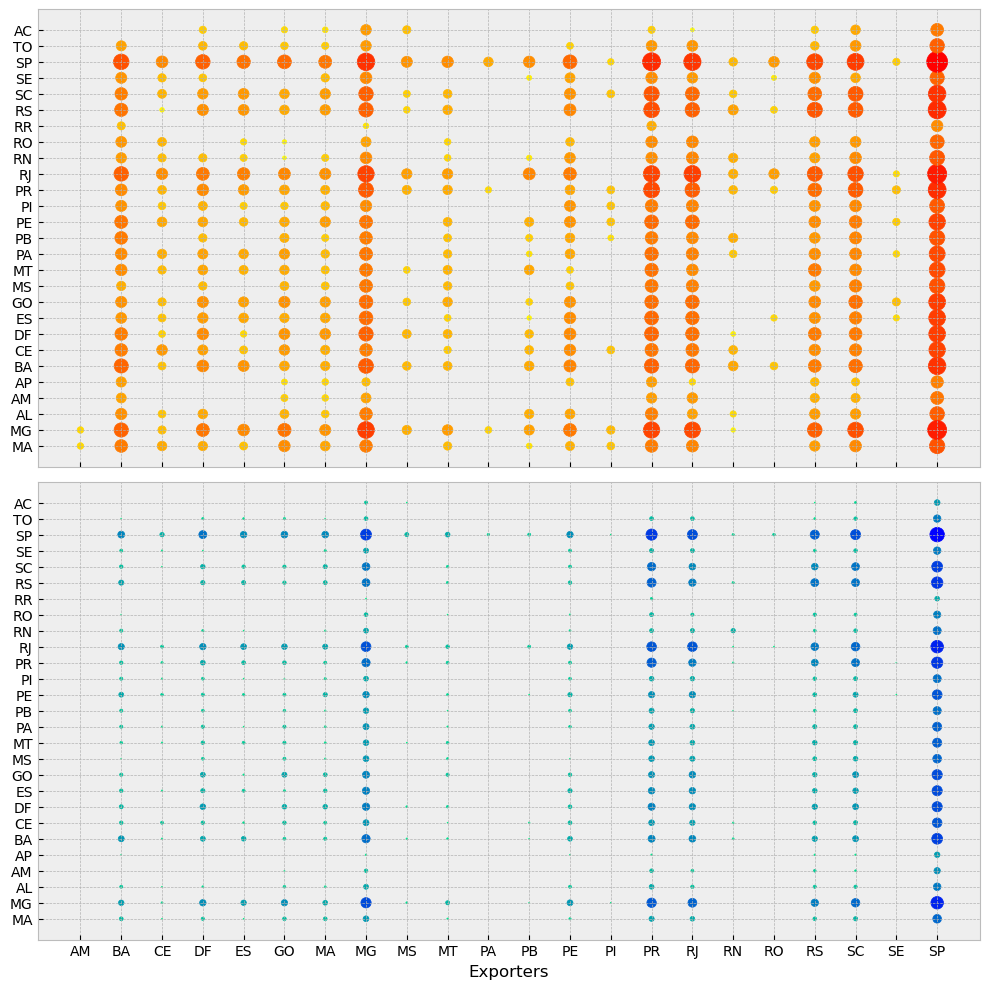

In [58]:
states_transactions = orders.groupby(["seller_state","customer_state"],as_index=False)["price"].sum()
states_amount_orders = (orders.groupby(["seller_state","customer_state"],as_index=False)["price"].count().
                        rename(columns={"price":"amount"}))
G_sum = nx.from_pandas_edgelist(states_transactions,"seller_state","customer_state",edge_attr="price")
G_count = nx.from_pandas_edgelist(states_amount_orders,"seller_state","customer_state",edge_attr="amount")

prices = [G_sum[u][v]["price"] for u,v in G_sum.edges()]
counts = [G_count[u][v]["amount"] for u,v in G_count.edges()]
prices = preprocessing.minmax_scale(np.log10(prices)**3,(0,1))
counts = preprocessing.minmax_scale(np.log10(counts)**3,(0,1))
fig, ax = plt.subplots(nrows=2,figsize=(10,10))
nx.draw_circular(G_sum,edge_color=prices,with_labels=True,
                 edge_cmap=plt.get_cmap("autumn_r"),width=prices,ax=ax[0])
nx.draw_circular(G_count,edge_color=counts,with_labels=True,
                 edge_cmap=plt.get_cmap("winter_r"),width=counts,ax=ax[1])
ax[0].set_title("Sum of money transaction betweeem states")
ax[1].set_title("Amount of orders betweeen states")
plt.tight_layout()

fig, ax = plt.subplots(nrows=2,figsize=(10,10),sharex=True)
ax[0].scatter(states_transactions["seller_state"],y=states_transactions["customer_state"],
              s=np.log(states_transactions["price"])**2,c=np.log(states_transactions["price"]),
             cmap="autumn_r")
ax[1].scatter(states_amount_orders["seller_state"],y=states_amount_orders["customer_state"],
              s=np.log(states_amount_orders["amount"])**2,c=np.log(states_amount_orders["amount"]),
              cmap=plt.get_cmap("winter_r"))
ax[1].set_xlabel("Exporters")

plt.tight_layout()

In [59]:
def plot_polar(x,y,ax,color="red",label=None):
    '''
    Given x, y and ax returns polar line plot
    '''

    x = np.array(x)
    y = np.array(y)
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    theta = np.deg2rad(np.linspace(0,360,len(x)))

    lines,labels = plt.thetagrids((np.linspace(0,360,len(x))),(x))
    
   
    ax.plot(theta,y,color=color,label=label,alpha=0.8)
    
    ax.fill_between(theta,y,alpha=0.1,color=color)
    
    return ax

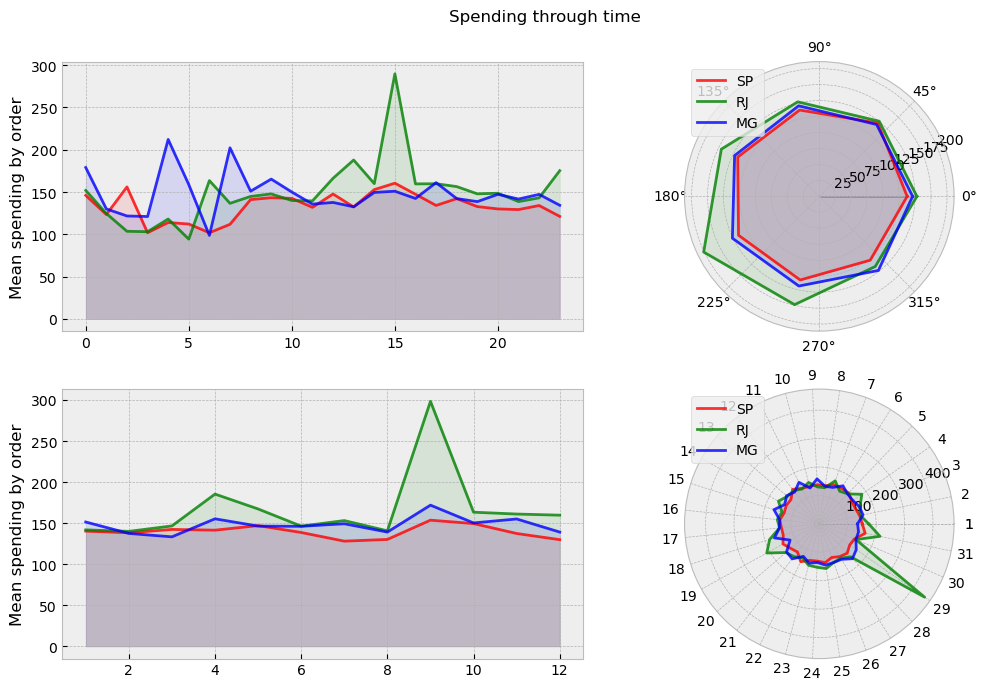

In [60]:
states=["SP","RJ","MG"]
fig = plt.figure(figsize=(11,7))
temp_columns = ['purchased_hour_day','purchased_week_day','purchased_month', 'purchased_day',
                   ]
colors = ["red","green","blue"]
#create axes
axes = [plt.subplot(2,2,i)  if (i%2!=0) else plt.subplot(2,2,i, polar=True) for i in range(1,len(temp_columns)+1)]

for i,ax in enumerate(axes):
    for j,state in enumerate(states):
        #group the data in convinient format for plotting
        orders_state = order_total[order_total["customer_state"]==state]
        data = orders_state[[temp_columns[i],"total_consumption"]].groupby(temp_columns[i]).mean()
        
        #plot
        if i%2!=0:
            plot_polar(data.index.values,data["total_consumption"].values,ax=ax,color=colors[j],label=state)
            ax.legend(loc="upper left")
            
        else:
            ax.plot(data.index,data["total_consumption"],color=colors[j],alpha=0.8)            
            ax.fill_between(data.index,data["total_consumption"],color=colors[j],alpha=0.1)
            ax.set_ylabel("Mean spending by order")
fig.suptitle("Spending through time")        
plt.tight_layout()          


In [61]:
categories_amount = (orders.groupby("category").
                     agg({"category":"count","price":["sum","median"]}).
                     sort_values(by=("category","count"),ascending=False))

In [62]:
def get_amount_percent(df,col,threshold):
    '''
    returns the categorical values 
    that are within the indicated threshold by amount of appeareance
    '''    
    X = df.copy()
    #check if the df is multilabeled
    if isinstance(col,tuple): 
        # cumulated sum and get percent
        X["acum"] = (X[col[0]][col[1]].cumsum() / X[col].sum())*100
        axis_threshold = X[X["acum"]<=threshold].index
    else:
        X["acum"] = (X[col].cumsum() / X[col].sum())*100
        axis_threshold = X[X["acum"]<=threshold].index
        
    return axis_threshold.values


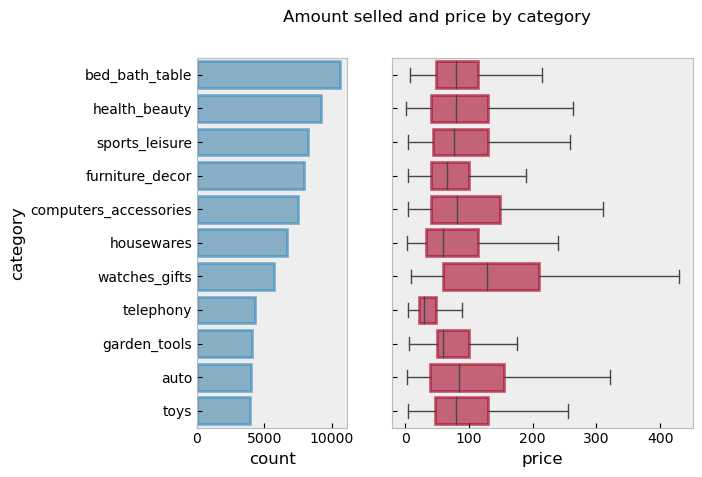

In [63]:
fig, ax = plt.subplots(ncols=2,sharey=True,width_ratios=[1,2])
colours = ["#348ABD", "#A60628"]
imp_cat = categories_amount.loc[get_amount_percent(categories_amount,("category","count"),70)]

sns.barplot(y=imp_cat.index,x=imp_cat["category"]["count"],ax=ax[0],orient="h",
            linewidth=2,color=colours[0],alpha=0.6,edgecolor=colours[0])
sns.boxplot(data=orders[orders["category"].isin(imp_cat.index)],
                y="category",x="price",showfliers=False,
            linewidth=1,boxprops=dict(color=colours[1],alpha=0.6,
                                      edgecolor=colours[1],linewidth=2),
            order=imp_cat.index)

ax[0].grid(False)
ax[1].grid(False)
ax[1].set_ylabel("")
fig.suptitle("Amount selled and price by category")
plt.show()

In [64]:
orders_by_state = orders.groupby(["seller_state","category"],as_index=False).agg({"price":["count","sum","mean","median"]}).reset_index()
orders_by_state = (orders_by_state[orders_by_state["seller_state"].isin(states)])
orders_by_state = orders_by_state[orders_by_state["category"].isin(imp_cat.index)].reset_index()

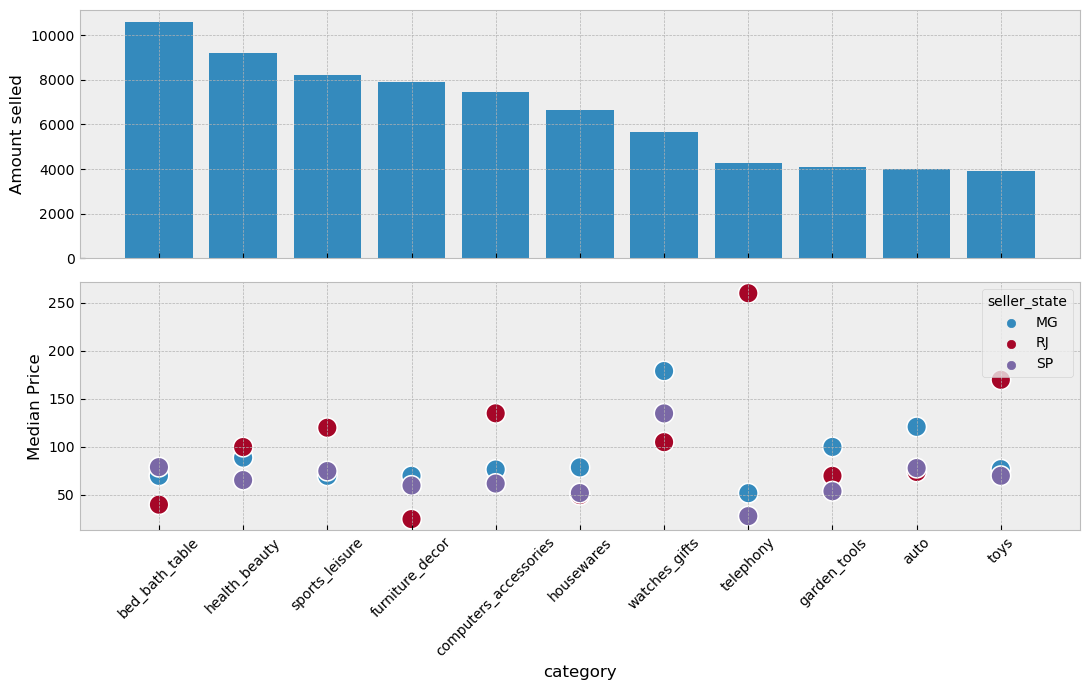

In [65]:
fig,ax = plt.subplots(2,1,figsize=(11,7),sharex=True)
imp_cat = categories_amount.loc[get_amount_percent(categories_amount,("category","count"),70)]
ax[0].bar(imp_cat.index,imp_cat.values[:,0])

ax[0].set_ylabel("Amount selled")
sns.scatterplot(data=orders_by_state,x="category",
                y=("price","median"),hue="seller_state",s=200)
ax[1].set_ylabel("Median Price")
ax[1].tick_params(axis="x",rotation=45)

plt.tight_layout()

/home/joaquim/miniconda3/envs/ecommerce/lib/python3.11/site-packages/seaborn/relational.py:982: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


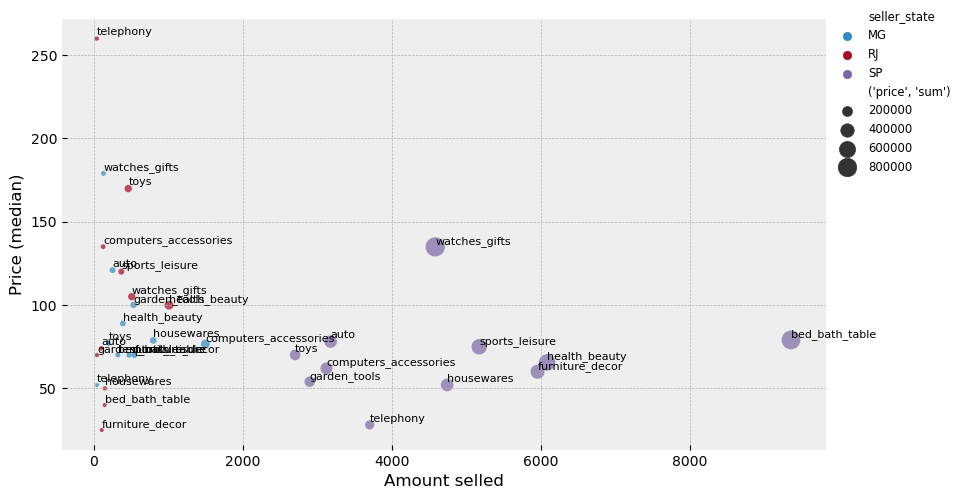

In [66]:
# create figure level and plot with seaborn
g = sns.relplot(
    data=orders_by_state,
    x=("price","count"), y=("price","median"),
    hue="seller_state", size=("price","sum"),
     sizes=(10, 200),height=5,aspect=1.7,alpha=0.7
)
# get the ax of the figure
ax = g.axes[0,0]

#add text to plot
for line in range(0,orders_by_state.shape[0]):    
    if orders_by_state["category"][line] in imp_cat.index:
        ax.text(orders_by_state["price"]["count"][line]+1,
              orders_by_state["price"]["median"][line]+2,
                orders_by_state["category"][line],size=8,horizontalalignment='left')
        
# add stuff for better looking
#g.set(xscale="asinh")
ax.set_ylabel("Price (median)")
ax.set_xlabel("Amount selled")

g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
sns.move_legend(obj=g, loc="upper right",fontsize="small")
plt.show()

In [67]:
orders_by_payment = orders.groupby(["customer_state","payment_type"],as_index=False).agg({"price":"mean"})
orders_by_payment = orders_by_payment[orders_by_payment["customer_state"].isin(states)].reset_index()


<Axes: xlabel='customer_state', ylabel='price'>

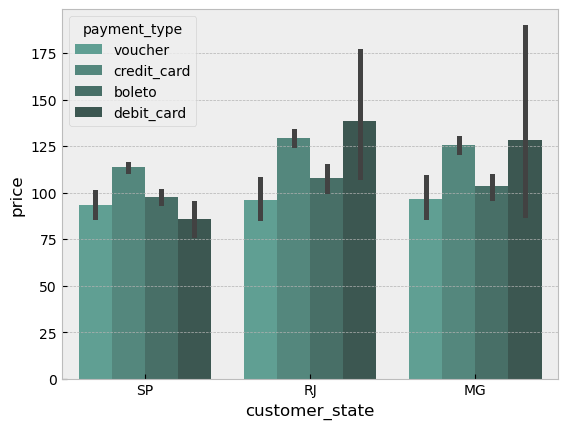

In [68]:
sns.barplot(data=orders[orders["customer_state"].isin(states)].reset_index(),
            x="customer_state",
            y="price",
            hue="payment_type",palette=sns.color_palette("dark:#5A9_r"),linewidth=3)

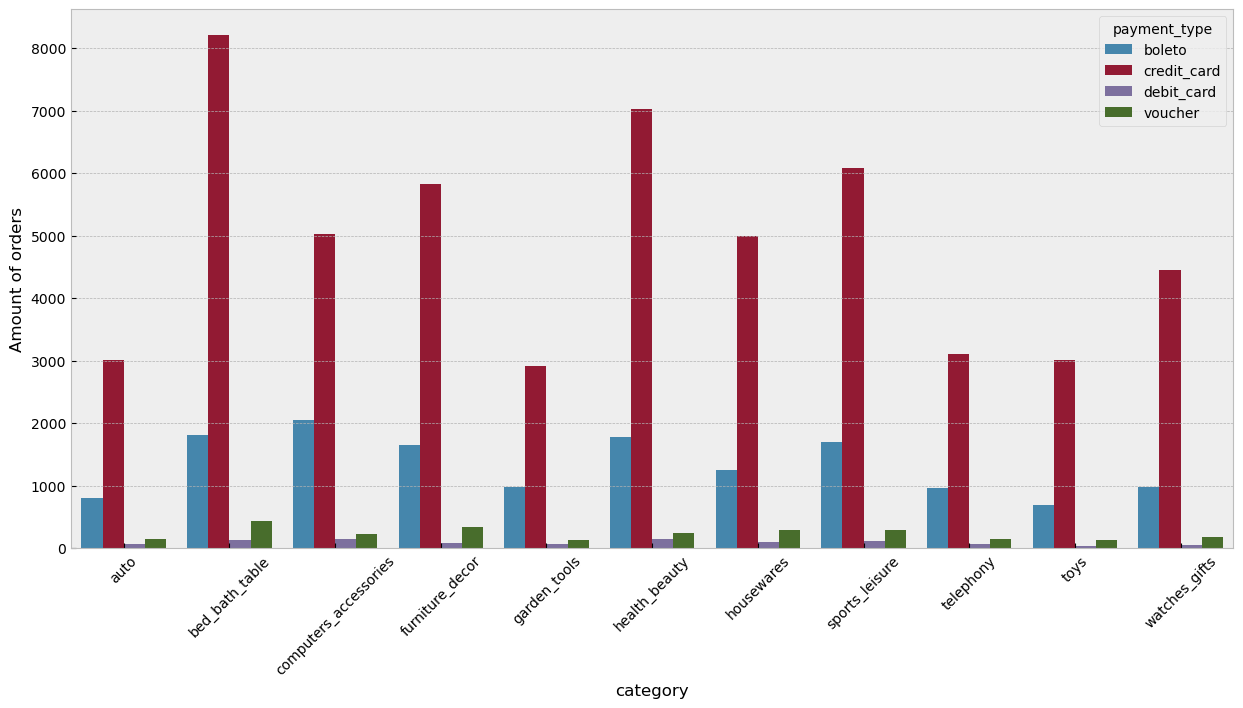

In [69]:
orders_state_cat = (orders[orders["category"].isin(imp_cat.index)]
                    .groupby(["category","payment_type"],as_index=False).
                    agg({"price":"count"}))
fig,ax = plt.subplots(figsize=(15,7))

sns.barplot(data=orders_state_cat,x="category",y="price",hue="payment_type",ax=ax)
ax.tick_params(axis="x",rotation=45)
ax.set_ylabel("Amount of orders")
plt.show()

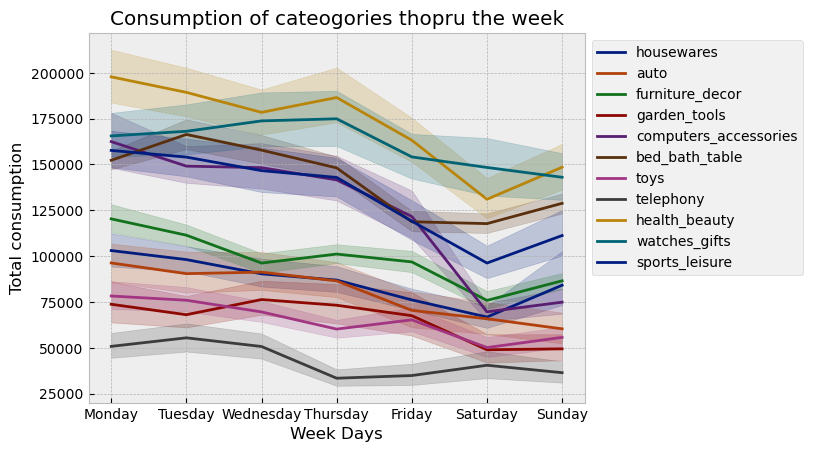

In [70]:
n_colors = len(orders[orders["category"].isin(imp_cat.index)]["category"].unique())
fig, ax = plt.subplots()
ax = sns.lineplot(data=orders[orders["category"].isin(imp_cat.index)],
             x="purchased_week_day",y="price",hue="category",
            estimator="sum",
            palette=sns.color_palette("dark",n_colors=n_colors))
ax.set_title("Consumption of cateogories thopru the week")
ax.set_ylabel("Total consumption")
ax.set_xticks(ticks=range(7),
              labels=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_xlabel("Week Days")
plt.legend(bbox_to_anchor=(1,1),loc="upper left")
plt.show()

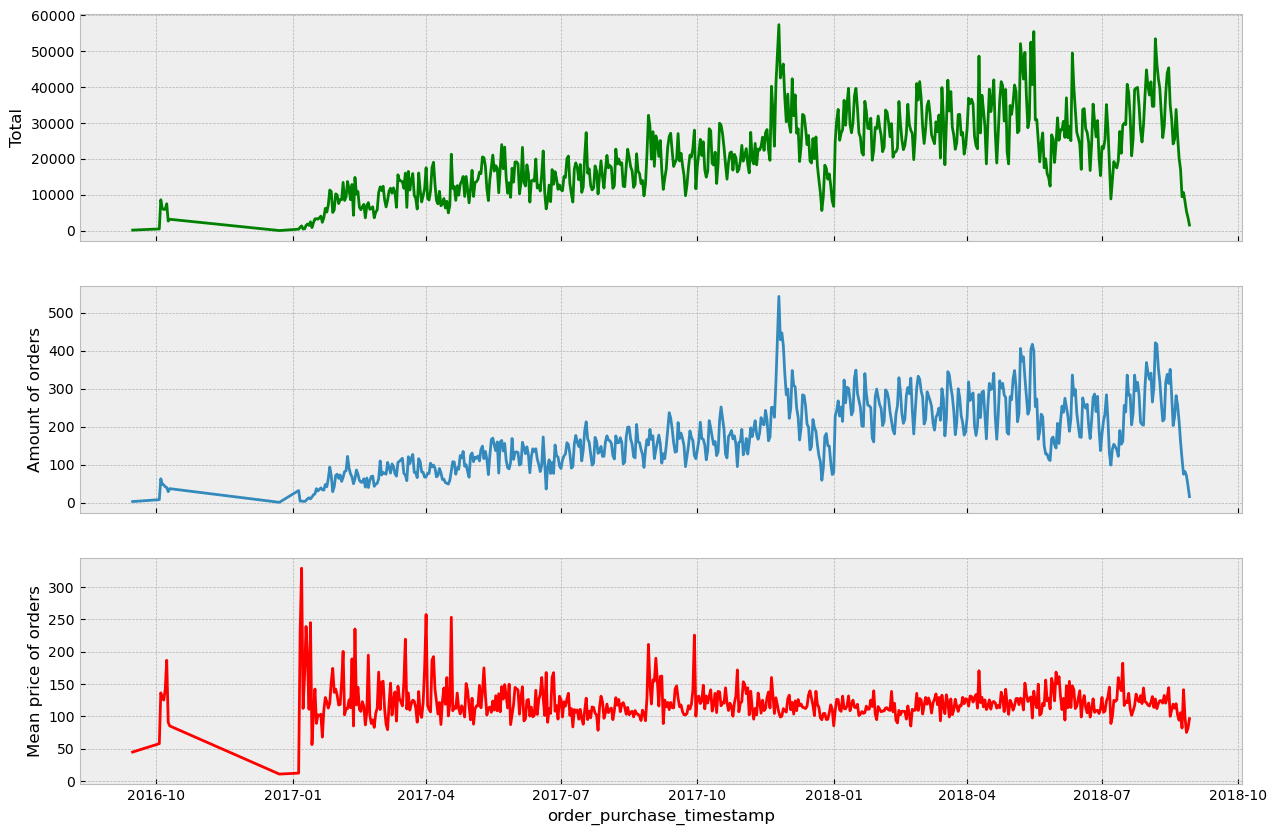

In [71]:
orders_time = orders.groupby("order_purchase_timestamp").agg({"price":["mean","sum","count"]}).reset_index()

fig, ax = plt.subplots(nrows=3,figsize=(15,10),sharex=True)
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","sum"),color="green",ax=ax[0])
ax[0].set_ylabel("Total")
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","count"),ax=ax[1])
ax[1].set_ylabel("Amount of orders")
sns.lineplot(data=orders_time,x="order_purchase_timestamp",y=("price","mean"),color="red",ax=ax[2])
ax[2].set_ylabel("Mean price of orders")
plt.show()

outlier_date = (orders_time.sort_values(("price","count"),
                                        ascending=False).iloc[:1]["order_purchase_timestamp"].values)[0]

#### Product analysis

In [73]:
products = orders[['product_id','product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'category','freight_value']].drop_duplicates()
products["volume_cm3"] = products["product_height_cm"] * products["product_length_cm"] * products["product_width_cm"]


<Axes: xlabel='volume_cm3', ylabel='freight_value'>

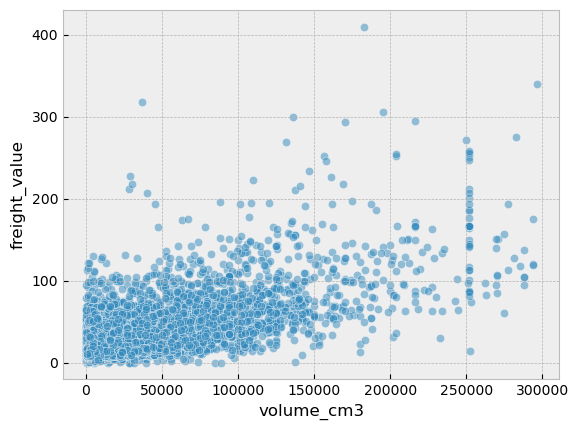

In [74]:
temp_prod = products.groupby("product_id").agg({"volume_cm3":"mean",
                                                "product_weight_g":"mean","freight_value":"mean"})
sns.scatterplot(data=temp_prod,x="volume_cm3",y="freight_value",alpha=0.5)

<Axes: xlabel='product_weight_g', ylabel='freight_value'>

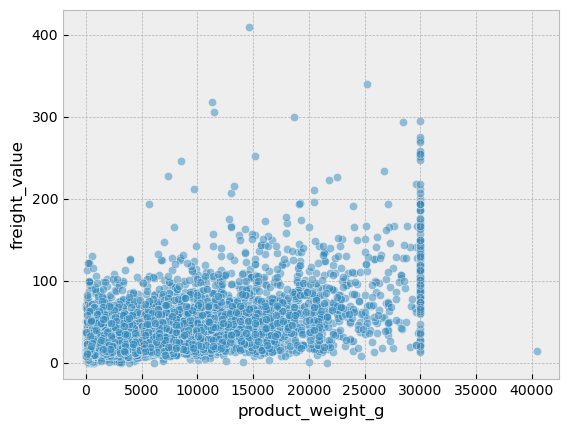

In [75]:
sns.scatterplot(data=temp_prod,x="product_weight_g",y="freight_value",alpha=0.5)

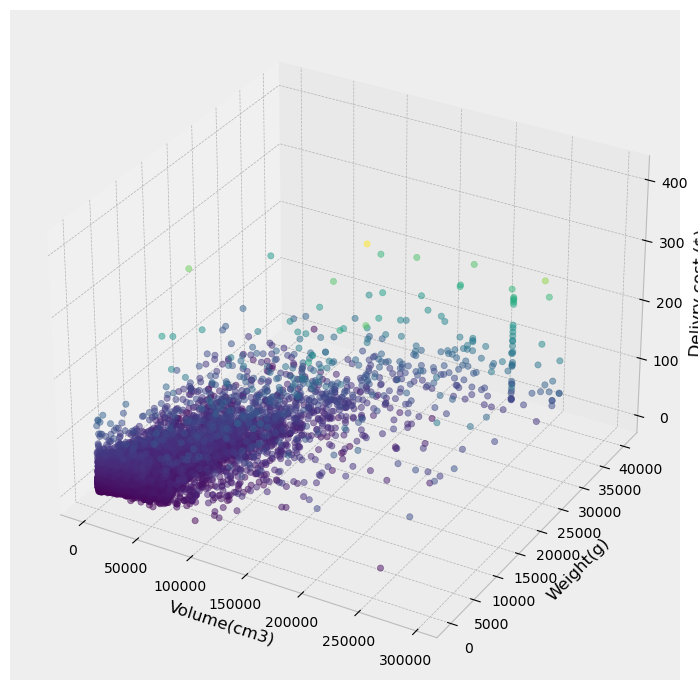

In [76]:
fig,ax = plt.subplots(subplot_kw={"projection":"3d"},figsize=(7,7))

ax.scatter(xs=temp_prod["volume_cm3"],ys=temp_prod["product_weight_g"],
           zs=temp_prod["freight_value"],c=temp_prod["freight_value"],
          alpha=0.5)

ax.set_xlabel("Volume(cm3)")
ax.set_ylabel("Weight(g)")
ax.set_zlabel("Delivry cost ($) ")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()


In [27]:
def plot_bars(df,x,y,ax,hue,width=0.25,estimator="mean"):    
    #utils
    width = width
    multiplier = 0
    df_grouped = df.groupby([x,hue],as_index=False).agg({y:estimator})    
    hues_unique = df_grouped[hue].unique()
    x_unique = df_grouped[x].unique()
    x_space = np.linspace(0,len(x_unique),len(x_unique))
    
    for hue_value in hues_unique:
        offset = width * multiplier
        values = df_grouped[df_grouped[hue]==hue_value][y]        
        rects = ax.bar(x_space+offset,values,width,label=hue_value,alpha=0.8)        
        multiplier+=1
        
    #aesthetic
    ax.set_ylabel('Mean price of products ($)')
    ax.set_title('Price by state and payment')
    ax.set_xticks(x_space + width, x_unique)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 250)
        
    return ax
        

In [ ]:
def plot_boxes(data,cat_col,value_col,categories=None):
    '''
    This function is based on this amazing article:
    https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/
    
    parameters:
        data: df containing all data
        cat_col: name of category column in data str
        categories: opt, list of categories you want to plot
        value_col: name of the num column in data str
    '''

    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
    if categories is None:
        categories = [x for x in data[cat_col].unique()]
    
    gs = grid_spec.GridSpec(len(categories),1)
    fig = plt.figure(figsize=(16,10))

    i = 0

    ax_objs = []

        
    for category in categories:
        
        #category = category[i]
                      
        x = data[data[cat_col] == category][value_col]
        

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        plot = np.log(x).plot.kde(ax=ax_objs[-1],yticks=[],xticks=[])
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        
        ax_objs[-1].fill_between(x,y, alpha=0.4,color="red")


        # setting uniform x and y lims
        #ax_objs[-1].set_xlim(-7,5)
        #ax_objs[-1].set_ylim(0,2.5)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])
        ax_objs[-1].set_ylabel('')


        ax_objs[-1].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        #adj_category = category.replace(" ","\n")
        ax_objs[-1].text(-0.02,0,category,fontsize=14,ha="right")

        ax_objs[-1].tick_params(grid_alpha=0)
        i += 1

    gs.update(hspace=-0.7)

    fig.text(0.07,0.85,"Distribution by category",fontsize=20)

    plt.show()

In [24]:
def plot_ridge(data,cat_col,value_col,categories=None,kernel="gaussian"):
    '''
    This function is based on this amazing article:
    https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/
    
    parameters:
        data: df containing all data
        cat_col: name of category column in data str
        categories: opt, list of categories you want to plot
        value_col: name of the num column in data str
    '''

    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
    if categories is None:
        categories = [x for x in data[cat_col].unique()]
    
    gs = grid_spec.GridSpec(len(categories),1)
    fig = plt.figure(figsize=(16,10))

    i = 0

    ax_objs = []

        
    for category in categories:
        
        #category = category[i]
                      
        x = data[data[cat_col] == category][value_col]
        

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        plot = np.log(x).plot.kde(ax=ax_objs[-1],yticks=[],xticks=[])
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        
        ax_objs[-1].fill_between(x,y, alpha=0.4,color="red")


        # setting uniform x and y lims
        #ax_objs[-1].set_xlim(-7,5)
        #ax_objs[-1].set_ylim(0,2.5)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])
        ax_objs[-1].set_ylabel('')


        ax_objs[-1].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        #adj_category = category.replace(" ","\n")
        ax_objs[-1].text(-0.02,0,category,fontsize=14,ha="right")

        ax_objs[-1].tick_params(grid_alpha=0)
        i += 1

    gs.update(hspace=-0.7)

    fig.text(0.07,0.85,"Distribution by category",fontsize=20)

    plt.show()

In [ ]:
gdp_brazil_1 = geopandas.read_file("brazil_geo/gadm41_BRA_1.shp")
#small prepro
gdp_brazil_1["HASC_1"] = gdp_brazil_1["HASC_1"].apply(lambda x: x.split(".")[1])

order_total_customer = order_total_customer.merge(right=gdp_brazil_1[["HASC_1","geometry"]],
                                                  left_on="customer_state",
                                                  right_on="HASC_1")

gdf_state = geopandas.GeoDataFrame(order_total_customer,geometry="geometry_y").drop(columns=["geometry_x"])




In [ ]:
ax = gdp_brazil_1.plot(color="white",edgecolor="black")
gdf_state.plot(column="total_consumption",cmap='OrRd',ax=ax)
ax.grid(linestyle="-.")

In [ ]:

ax = world[world.name == 'Brazil'].plot(color="white",edgecolor="black")


gdf_sellers.plot(ax=ax,alpha=0.1)

ax.grid(linestyle="-.")


plt.show()

In [ ]:
gdf_state.groupby("HASC_1",as_index=False).agg({"total_consumption":"sum","freight_value":"mean",
                                 "sellers_amount":"sum",
                                "daysToDeliver":"mean",
                                "purchased_month":"mean",
                                "purchased_hour_day":"mean",
                                "purchased_day":"mean",
                                "purchased_week_day":"mean"})

In [21]:
#Adding geolocalation to customers and sellers
geolocation_simplifed = geolocation.groupby("geolocation_zip_code_prefix").mean()

sellers = sellers.merge(right=geolocation_simplifed,how="left",left_on="seller_zip_code_prefix",
              right_on=geolocation_simplifed.index)

customer = custumer.merge(right=geolocation_simplifed,how="left",left_on="customer_zip_code_prefix",
               right_on=geolocation_simplifed.index)
# filter rows with wrong geolocation 
customer = customer[customer["geolocation_lng"]<-30]

/tmp/ipykernel_513/3161804356.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  geolocation_simplifed = geolocation.groupby("geolocation_zip_code_prefix").mean()


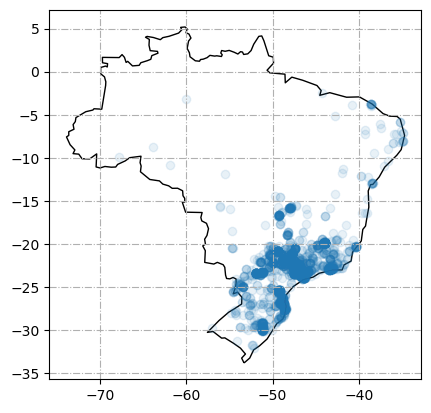

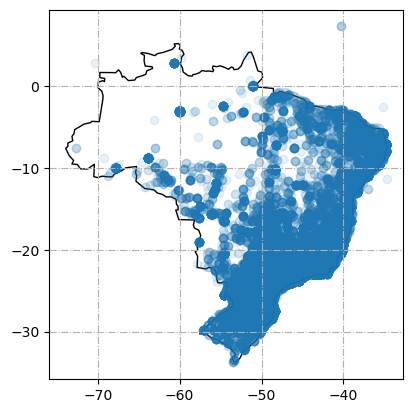

In [22]:
gdf_sellers = geopandas.GeoDataFrame(data=sellers,
                             geometry=geopandas.points_from_xy(sellers.geolocation_lng,
                                                               sellers.geolocation_lat))
gdf_customers = geopandas.GeoDataFrame(data=customer,
                             geometry=geopandas.points_from_xy(customer.geolocation_lng,
                                                               customer.geolocation_lat))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.name == 'Brazil'].plot(color="white",edgecolor="black")
ax2 =  world[world.name == 'Brazil'].plot(color="white",edgecolor="black")
# We can now plot our ``GeoDataFrame``.
gdf_sellers.plot(ax=ax,alpha=0.1)
gdf_customers.plot(ax=ax2,alpha=0.1)
ax.grid(linestyle="-.")
ax2.grid(linestyle="-.")

plt.show()